In [1]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

import PIL

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

tf.get_logger().setLevel('ERROR')

## Utilities

Run the following cell to create some utils that will be needed later:

- Helper method to load an image
- Map of Model Name to TF Hub handle

In [2]:
def load_image_into_numpy_array(path):
    """
    Load an image from file into a numpy array. Extra dimension added for batching
    """
    with Image.open(path) as image:
        (im_width, im_height) = image.size    
        image = np.asarray(image)

    return image.reshape((1, im_height, im_width, 3)).astype(np.uint8)

## Load label map data (for plotting)

In [3]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

label_offsets = {3:"car", 6:"bus", 8:"truck"}

## Build a detection model and load pre-trained model weights

In [4]:
print('loading model...')
hub_model = hub.load('ALL_MODELS/CenterNet HourGlass104 512x512/1')
print('model loaded!')

loading model...


model loaded!


## Doing the inference

In [5]:
parent_dir = r"test_images/"
image_files = os.listdir(parent_dir)

# holds information for cropping
image_files_dict = {}

# running the detector for each image
image_path = "test_images/1.jpg" ##[parent_dir+image_files]
image_np = load_image_into_numpy_array(image_path)

# running inference
results = hub_model(image_np)

# different object detection models have additional results
# all of them are explained in the documentation
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

dict_keys(['detection_boxes', 'num_detections', 'detection_scores', 'detection_classes'])


## Visualizing the results
Here you can, for example, set `min_score_thresh` to other values (between 0 and 1) to allow more detections in or to filter out more detections.

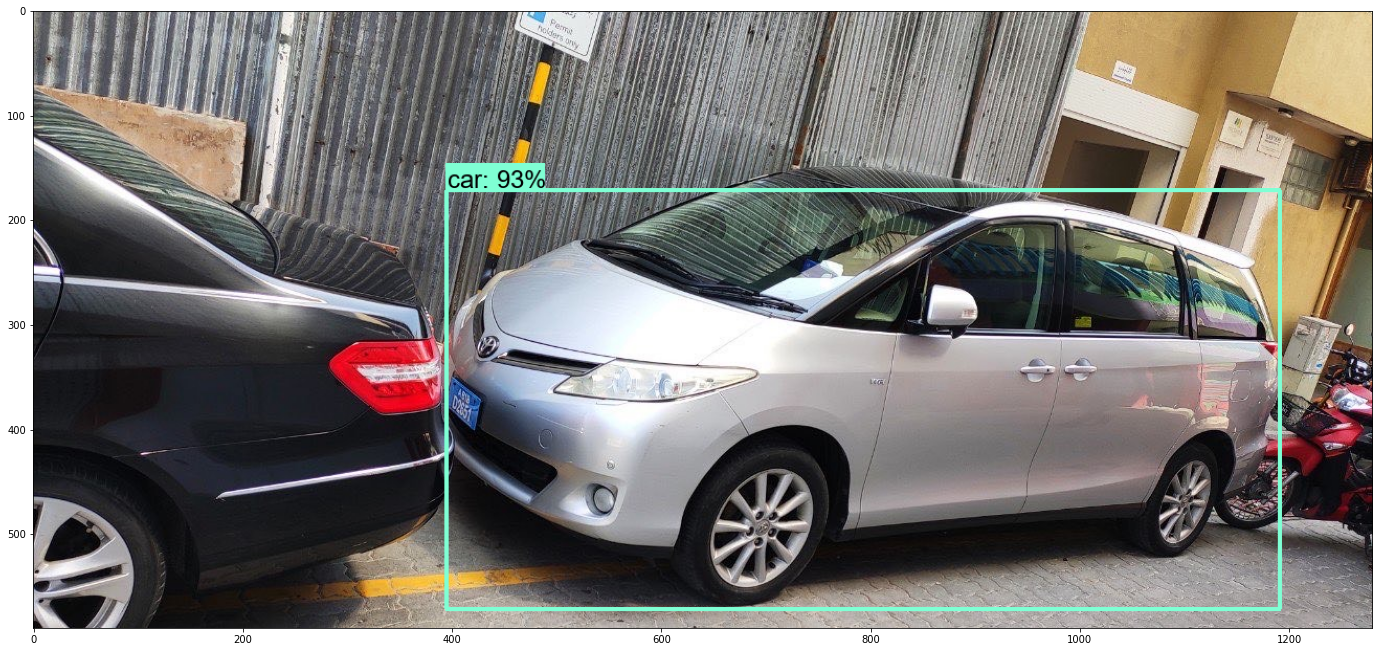

In [6]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

# filter cars from all the detections
detection_scores = []
detection_classes = []
detection_boxes = []

cars = label_offsets.keys()
maximumArea = -1 # biggest bounding box that has car
_, width, height, _ = image_np.shape # image dimensions
for score, category, boxes in zip(result['detection_scores'][0], (result['detection_classes'][0] + label_id_offset).astype(int), result['detection_boxes'][0]):
    if score < 0.3:
        break
        
    if category not in cars:
        continue
    
    upper = height*boxes[0]
    left = width*boxes[1]
    lower = height*boxes[2]
    right = width*boxes[3]
            
    area = abs(upper-lower)*abs(left-right)
            
            # if area bigger than current max, replace
    if area > maximumArea:
        detection_scores = [score]
        detection_classes = [category]
        detection_boxes = [boxes] 

detection_scores = np.array(detection_scores)
detection_classes = np.array(detection_classes)
detection_boxes = np.array(detection_boxes)
    
## visualize the bounding boxes
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      detection_boxes,
      detection_classes,
      detection_scores,
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()